# Notebook 3 — Treino, Avaliação e Análise (Ambiente Original vs. Ambiente Modificado)

**Autores:** Francisca Cerqueira, Iara Ferreira, Rodrigo Simões

**Data:** Dezembro 2025  

**Unidade Curricular:** Introdução aos Sistemas Inteligentes e Autónomos

---

### Índice
1. [Avaliação determinística cruzada (baseline vs. modificado)](#sec1)  

2. [Treino do agente no ambiente modificado (InjuredBipedalWalker)](#sec2)  

3. [Análise Comportamental e Comparação de Resultados](#sec3)  

4. [Conclusão](#sec4)

---
Nesta fase final, avaliamos **robustez** e **capacidade de adaptação** de agentes treinados com TD3, comparando:
- **Treino no ambiente baseline** e teste em **baseline vs modificado** 
- **Treino no ambiente modificado** e teste em **baseline vs modificado** 

Mantemos a separação entre:
- **Curvas de aprendizagem (treino)**: sinal com ruído de exploração (diagnóstico qualitativo de tendência/estabilidade).
- **Avaliação determinística (teste)**: desempenho final real (média e variância sobre múltiplas seeds/episódios).

In [58]:
import sys
import os

sys.path.append(os.path.abspath(".."))

import gymnasium as gym
import my_envs # O ambiente da perna partida (InjuredBipedalWalker-v0)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from stable_baselines3 import TD3
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from stable_baselines3.common.noise import NormalActionNoise
from IPython.display import HTML

# Configuração visual
%matplotlib inline
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Criar pastas para a Fase 3
LOG_TUNING = "../logs/fase3_injured"
MODEL_TUNING = "../models/fase3_injured"

os.makedirs("../models/fase3_injured", exist_ok=True)
os.makedirs("../logs/fase3_injured", exist_ok=True)

# Destinguir entre os dois tipos de ambiente
ENV_ID_BASELINE = "BipedalWalker-v3"          # Ambiente baseline
ENV_ID_MODIFIED = "InjuredBipedalWalker-v0"    # Ambiente modificado

print("Ambiente e bibliotecas carregados com sucesso!")



Ambiente e bibliotecas carregados com sucesso!


No *Notebook 2* identificámos o **TD3** como o algoritmo mais adequado para o `BipedalWalker-v3` e selecionámos como baseline final a configuração **“Míope”** (*learning_rate* = 0.001, **γ = 0.98**).  
Nesta etapa, esse modelo é usado como **referência** para medir a degradação de desempenho quando a dinâmica é alterada (ambiente modificado) e para justificar a necessidade de treino e tuning no novo cenário.

In [37]:
# algoritmo com melhor performance na fase anterior
ALGO_NAME = "TD3"
# modelo baseline treinado na fase 2
PATH_MODELO_BASELINE = "../models/tun_selection/TD3_Miope.zip" 
# Verificar se o modelo baseline existe e está acessível
if not os.path.exists(PATH_MODELO_BASELINE):
    print(f"AVISO: Não encontrei o modelo em '{PATH_MODELO_BASELINE}'.")
else:
    print(f"Modelo baseline encontrado: {PATH_MODELO_BASELINE}")

Modelo baseline encontrado: ../models/tun_selection/TD3_Miope.zip


Definição de algumas funções auxiliares.

In [ ]:
def plot_training_curves(log_folder, title="Curva de Aprendizagem (Treino)", window=10):
    """
    Lê os logs do TensorBoard (com ruído de exploração) e desenha a evolução suavizada.
    """
    data = []
    if not os.path.exists(log_folder):
        print(f"Pasta {log_folder} não encontrada.")
        return

    subfolders = [f.path for f in os.scandir(log_folder) if f.is_dir()]
    
    for folder in subfolders:
        event_files = [f for f in os.listdir(folder) if "events.out.tfevents" in f]
        if not event_files: continue
        
        event_path = os.path.join(folder, event_files[0])
        run_name = os.path.basename(folder)
        
        try:
            ea = EventAccumulator(event_path)
            ea.Reload()
            if 'rollout/ep_rew_mean' in ea.Tags()['scalars']:
                scalars = ea.Scalars('rollout/ep_rew_mean')
                steps = [s.step for s in scalars]
                values = [s.value for s in scalars]
                
                # Suavização (Rolling Mean) para limpar o ruído visual
                series = pd.Series(values)
                smoothed = series.rolling(window=window, min_periods=1).mean()
                
                for step, val in zip(steps, smoothed):
                    data.append({"Run": run_name, "Timesteps": step, "Reward": val})
        except Exception as e:
            print(f"Erro a ler {run_name}: {e}")

    if data:
        plt.figure(figsize=(12, 6))
        sns.lineplot(data=pd.DataFrame(data), x="Timesteps", y="Reward", hue="Run", palette="tab10", linewidth=2)
        plt.title(title)
        plt.axhline(300, color="green", linestyle="--", label="Objetivo (300)")
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
    else:
        print("Sem dados de treino para mostrar.")

def rigorous_eval(model_path, AlgoClass, env_id="BipedalWalker-v3", episodes=20):
    """
    Carrega um modelo e testa-o em modo DETERMINÍSTICO (sem ruído).
    Retorna a média e desvio padrão reais.
    """
    if not os.path.exists(model_path):
        return None, None
        
    model = AlgoClass.load(model_path, device="cpu")
    env = gym.make(env_id)
    
    rewards = []
    for _ in range(episodes):
        obs, _ = env.reset()
        done = False
        truncated = False
        total = 0
        while not (done or truncated):
            action, _ = model.predict(obs, deterministic=True) # Modo DETERMINÍSTICO
            obs, r, done, truncated, _ = env.step(action)
            total += r
        rewards.append(total)
    
    env.close()
    return np.mean(rewards), np.std(rewards)

def rigorous_eval_seeds(
    model_path,
    AlgoClass,
    env_id,
    seeds,
    episodes_per_seed=20,
    device="cpu",
):
    """
    Avaliação determinística (sem ruído) para várias seeds.

    Retorna:
      - df: resultados por seed (mean/std)
      - summary: (mean_over_seeds, std_over_seeds)
    """
    if not os.path.exists(model_path):
        return None, (None, None)

    rows = []
    for seed in seeds:
        env = gym.make(env_id)
        env.reset(seed=seed)

        model = AlgoClass.load(model_path, env=env, device=device)

        ep_returns = []
        for ep in range(episodes_per_seed):
            obs, _ = env.reset(seed=seed + ep)
            done, truncated = False, False
            total = 0.0

            while not (done or truncated):
                action, _ = model.predict(obs, deterministic=True)
                obs, r, done, truncated, _ = env.step(action)
                total += float(r)

            ep_returns.append(total)

        env.close()

        rows.append({
            "env_id": env_id,
            "seed": seed,
            "episodes": episodes_per_seed,
            "mean_return": float(np.mean(ep_returns)),
            "std_return": float(np.std(ep_returns)),
        })

    df = pd.DataFrame(rows)

    # Agregação por seed
    mean_over_seeds = float(df["mean_return"].mean())
    std_over_seeds  = float(df["mean_return"].std(ddof=1)) if len(df) > 1 else 0.0

    return df, (mean_over_seeds, std_over_seeds)

<a id="sec1"></a>
## 1. Avaliação determinística cruzada (baseline vs. modificado)

Nesta secção avaliamos **o mesmo modelo** (TD3-Míope treinado no `BipedalWalker-v3`) em modo **determinístico** (`deterministic=True`) em dois contextos:

1. **Ambiente baseline** (`BipedalWalker-v3`) — referência “saudável”.
2. **Ambiente modificado** (`InjuredBipedalWalker-v0`) — cenário problemático (perda de força numa perna).

O objetivo é quantificar a degradação de desempenho causada por uma alteração **puramente dinâmica** (o espaço de observações e a estrutura da recompensa mantêm-se), isolando o efeito da falha mecânica.

**Métrica principal:** retorno acumulado por episódio (return).  
**Métricas de consistência:** variabilidade **entre seeds** (sensibilidade ao terreno) e variabilidade **intra-seed** (dispersão entre episódios no mesmo regime de geração).



In [17]:
seeds = [0, 1, 2, 3, 4]

df_base, (m_base, s_base) = rigorous_eval_seeds(
    PATH_MODELO_BASELINE, TD3, ENV_ID_BASELINE, seeds, episodes_per_seed=20
)
df_inj, (m_inj, s_inj) = rigorous_eval_seeds(
    PATH_MODELO_BASELINE, TD3, ENV_ID_MODIFIED, seeds, episodes_per_seed=20
)

display(df_base)
display(df_inj)

print(f"Baseline: mean(seeds)={m_base:.2f} | std(seeds)={s_base:.2f}")
print(f"Injured : mean(seeds)={m_inj:.2f} | std(seeds)={s_inj:.2f}")


,env_id,seed,episodes,mean_return,std_return
0,BipedalWalker-v3,0,20,278.190051,1.582156
1,BipedalWalker-v3,1,20,278.046826,1.608795
2,BipedalWalker-v3,2,20,278.157692,1.703969
3,BipedalWalker-v3,3,20,278.418377,1.386691
4,BipedalWalker-v3,4,20,278.249946,1.764870


,env_id,seed,episodes,mean_return,std_return
0,InjuredBipedalWalker-v0,0,20,29.947464,66.248777
1,InjuredBipedalWalker-v0,1,20,27.582141,71.334990
2,InjuredBipedalWalker-v0,2,20,32.037114,73.057984
3,InjuredBipedalWalker-v0,3,20,25.350963,70.169719
4,InjuredBipedalWalker-v0,4,20,21.849907,69.067626


Baseline: mean(seeds)=278.21 | std(seeds)=0.14
Injured : mean(seeds)=27.35 | std(seeds)=3.97


C:\Users\franc\AppData\Local\Temp\ipykernel_11112\714151589.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


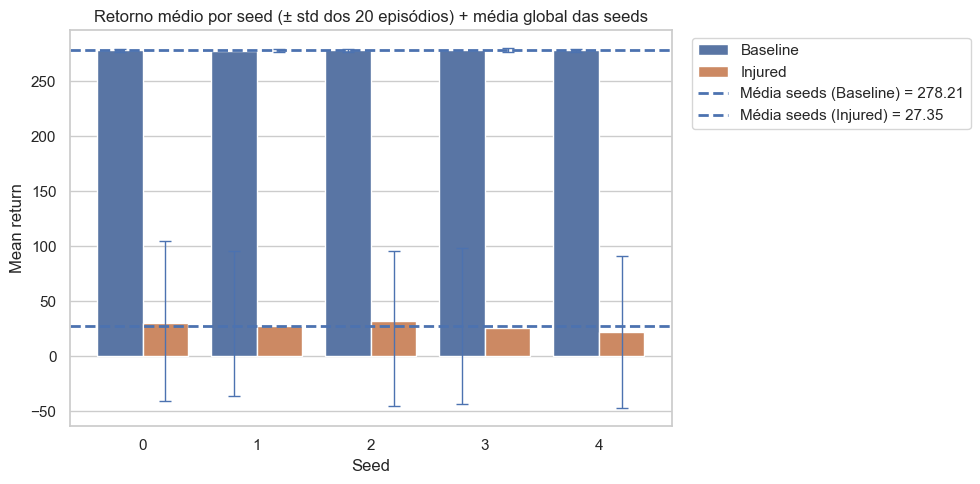

In [ ]:
df_plot = pd.concat([
    df_base.assign(Ambiente="Baseline"),
    df_inj.assign(Ambiente="Injured")
], ignore_index=True)

plt.figure(figsize=(10, 5))
ax = sns.barplot(
    data=df_plot,
    x="seed",
    y="mean_return",
    hue="Ambiente",
    ci=None
)

df_plot_sorted = df_plot.sort_values(["seed", "Ambiente"]).reset_index(drop=True)

for patch, (_, row) in zip(ax.patches, df_plot_sorted.iterrows()):
    x = patch.get_x() + patch.get_width() / 2
    y = row["mean_return"]
    yerr = row["std_return"]
    ax.errorbar(x=x, y=y, yerr=yerr, fmt="none", capsize=4, linewidth=1)

# linhas da média entre seeds (variância entre-seeds)
plt.axhline(m_base, linestyle="--", linewidth=2, label=f"Média seeds (Baseline) = {m_base:.2f}")
plt.axhline(m_inj,  linestyle="--", linewidth=2, label=f"Média seeds (Injured) = {m_inj:.2f}")

plt.title("Retorno médio por seed (± std dos 20 episódios) + média global das seeds")
plt.xlabel("Seed")
plt.ylabel("Mean return")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

Os resultados evidenciam uma assimetria clara entre desempenho:

- No ambiente baseline, o TD3-Míope apresenta desempenho **elevado e extremamente estável** (**278.21 ± 0.14** entre seeds), sugerindo uma política madura e reprodutível.
- No ambiente modificado, observa-se uma **degradação severa** (média **27.35 ± 3.97** entre seeds). Além disso, o desvio-padrão **intra-seed** (≈ 66–73) é muito elevado, indicando episódios altamente variáveis, tipicamente compatíveis com **falhas frequentes** (p. ex., quedas ou terminação precoce) em certas trajectórias.

Esta queda abrupta é consistente com a interpretação de que a política aprendida no ambiente saudável explora implicitamente a **simetria dinâmica** do robô. Ao introduzir uma limitação estrutural (redução de força num subconjunto de atuadores), a estratégia torna-se inadequada, e o agente não “reorganiza” a marcha sem retreino.

**Implicação:** para obter um desempenho representativo no cenário modificado e um *upper bound* credível, é necessário **treinar diretamente** no ambiente modificado e, potencialmente, ajustar hiperparâmetros que controlam exploração e estabilidade.


<a id="sec2"></a>
## 2. Treino do agente no ambiente modificado (InjuredBipedalWalker)

Após quantificar a degradação do baseline treinado no ambiente saudável, treinamos agentes **diretamente** no ambiente modificado (`InjuredBipedalWalker-v0`). O objetivo é duplo:

1. **Obter um limite superior (*upper bound*)**: estimar o melhor desempenho atingível quando a política é otimizada para a dinâmica lesionada, em vez de apenas transferida do ambiente saudável.
2. **Avaliar adaptação e estabilidade**: verificar se o TD3 aprende um padrão de marcha alternativo e quão consistente é essa política (variância do retorno).

### 2.1 Justificação dos hiperparâmetros avaliados
Mantemos o tempo de treino fixo (**300k timesteps**) e variamos hiperparâmetros com impacto direto em adaptação no controlo contínuo:

- **Exploração (ruído de ação, σ):** controla a amplitude das perturbações nas ações durante o treino. No ambiente lesionado, pode ser necessário explorar mais para descobrir estratégias compensatórias; ruído excessivo, contudo, pode degradar estabilidade.
- **Horizonte (γ):** afeta a atribuição de crédito e a variância dos alvos de valor. Alterar γ pode mudar o compromisso entre controlo mais reativo (γ menor) e otimização de retornos mais longos (γ maior).

As curvas de treino servem como **diagnóstico qualitativo**; a seleção final baseia-se na avaliação determinística.

In [20]:
TIMESTEPS_PHASE3 = 300_000
GLOBAL_SEED = 42

configs = [
    {"name": "Sigma0.05",  "lr": 1e-3, "gamma": 0.99,  "sigma": 0.05},
    {"name": "Sigma0.10",  "lr": 1e-3, "gamma": 0.99,  "sigma": 0.10},
    {"name": "Sigma0.20",  "lr": 1e-3, "gamma": 0.99,  "sigma": 0.20},
    {"name": "Gamma0.98",  "lr": 1e-3, "gamma": 0.98,  "sigma": 0.10},
    {"name": "Gamma0.99",  "lr": 1e-3, "gamma": 0.99,  "sigma": 0.10},
    {"name": "Gamma0.995", "lr": 1e-3, "gamma": 0.995, "sigma": 0.10},
]

print(f"--- FASE 3: TUNING DO TD3 (Seed {GLOBAL_SEED}) no ambiente modificado ({ENV_ID_MODIFIED}) ---")

for conf in configs:
    run_id = f"TD3_{conf['name']}"
    path_save = os.path.join(MODEL_TUNING, run_id)

    print(f"🔄 A treinar: {conf['name']} | LR={conf['lr']} | gamma={conf['gamma']} | sigma={conf['sigma']}")

    env = gym.make(ENV_ID_MODIFIED)
    env.reset(seed=GLOBAL_SEED)

    # action noise conforme a config
    n_actions = env.action_space.shape[-1]
    action_noise = NormalActionNoise(
        mean=np.zeros(n_actions),
        sigma=conf["sigma"] * np.ones(n_actions)
    )

    try:
        model = TD3(
            "MlpPolicy",
            env,
            learning_rate=conf["lr"],
            gamma=conf["gamma"],
            seed=GLOBAL_SEED,
            action_noise=action_noise,
            verbose=0,
            tensorboard_log=LOG_TUNING
        )

        model.learn(total_timesteps=TIMESTEPS_PHASE3, tb_log_name=run_id)
        model.save(path_save)
        print(f"✅ {conf['name']} concluído e guardado em {path_save}.zip")

    except Exception as e:
        print(f"❌ Erro ({conf['name']}): {e}")

    finally:
        env.close()


--- FASE 3: TUNING DO TD3 (Seed 42) no ambiente modificado (InjuredBipedalWalker-v0) ---
🔄 A treinar: Sigma0.05 | LR=0.001 | gamma=0.99 | sigma=0.05
✅ Sigma0.05 concluído e guardado em ../models/fase3_injured\TD3_Sigma0.05.zip
🔄 A treinar: Sigma0.10 | LR=0.001 | gamma=0.99 | sigma=0.1
✅ Sigma0.10 concluído e guardado em ../models/fase3_injured\TD3_Sigma0.10.zip
🔄 A treinar: Sigma0.20 | LR=0.001 | gamma=0.99 | sigma=0.2
✅ Sigma0.20 concluído e guardado em ../models/fase3_injured\TD3_Sigma0.20.zip
🔄 A treinar: Gamma0.98 | LR=0.001 | gamma=0.98 | sigma=0.1
✅ Gamma0.98 concluído e guardado em ../models/fase3_injured\TD3_Gamma0.98.zip
🔄 A treinar: Gamma0.99 | LR=0.001 | gamma=0.99 | sigma=0.1
✅ Gamma0.99 concluído e guardado em ../models/fase3_injured\TD3_Gamma0.99.zip
🔄 A treinar: Gamma0.995 | LR=0.001 | gamma=0.995 | sigma=0.1
✅ Gamma0.995 concluído e guardado em ../models/fase3_injured\TD3_Gamma0.995.zip


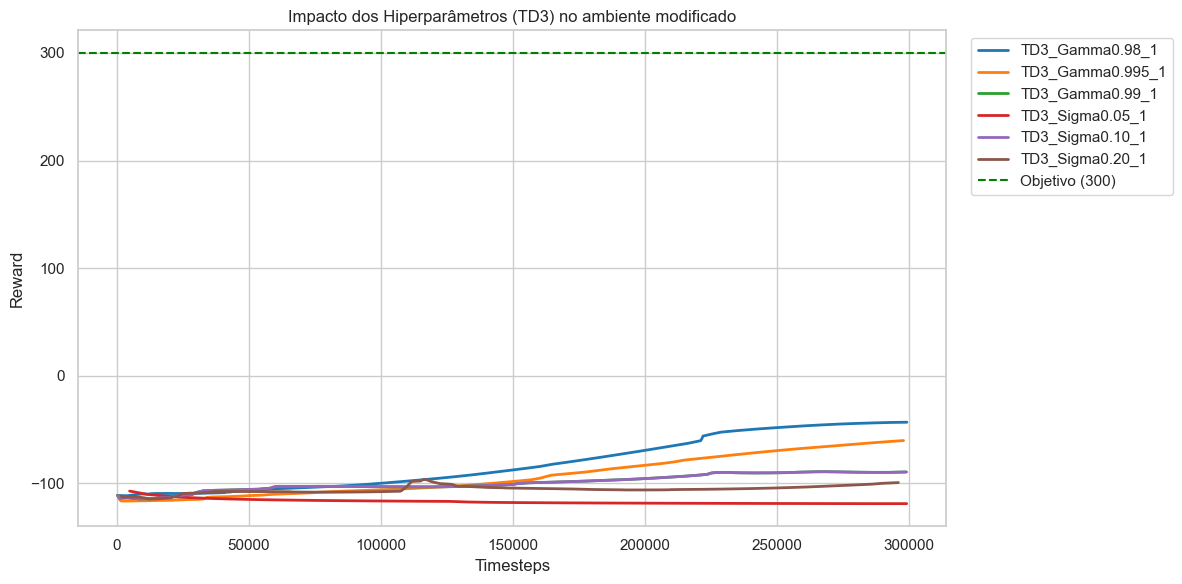

In [25]:
plot_training_curves(LOG_TUNING, title=f"Impacto dos Hiperparâmetros (TD3) no ambiente modificado", window=20)

### 2.3 Avaliação determinística e seleção do modelo “upper bound”

Após o treino, avaliamos cada configuração em modo determinístico em dois ambientes:

- **No ambiente modificado:** mede a eficácia de adaptação (critério principal nesta fase).
- **No ambiente baseline:** mede transferência inversa e permite discutir se a política “especializada” no lesionado perde competência no cenário saudável.

A seleção do melhor modelo deve privilegiar **desempenho no ambiente modificado** (como *upper bound*), mas a análise de transferência é relevante para discutir generalização.

In [27]:
def resolve_model_path(base_path):
    """Aceita base_path sem extensão e devolve o caminho existente."""
    if os.path.exists(base_path):
        return base_path
    if os.path.exists(base_path + ".zip"):
        return base_path + ".zip"
    return None


In [28]:
results_phase3 = []

print("--- FASE 3: AVALIAÇÃO DETERMINÍSTICA (MODELOS TREINADOS NO INJURED) ---")

for conf in configs:
    run_id = f"TD3_{conf['name']}"

    base_path = os.path.join(MODEL_TUNING, run_id)
    path = resolve_model_path(base_path)
    if path is None:
        print(f"⚠️  Modelo não encontrado (skip): {base_path}(.zip)")
        continue

    mean_base, std_base = rigorous_eval(path, TD3, env_id=ENV_ID_BASELINE, episodes=20)
    mean_inj, std_inj   = rigorous_eval(path, TD3, env_id=ENV_ID_MODIFIED, episodes=20)

    if mean_base is None or mean_inj is None:
        print(f"⚠️  Falha na avaliação (skip): {run_id}")
        continue

    results_phase3.append({
        "Config": conf["name"],
        "LR": conf["lr"],
        "Gamma": conf["gamma"],
        "Sigma": conf["sigma"],
        "Mean@Baseline": float(mean_base),
        "Std@Baseline": float(std_base),
        "Mean@Injured": float(mean_inj),
        "Std@Injured": float(std_inj),
    })

    print(f"✅ {conf['name']}: Baseline={mean_base:.2f}±{std_base:.2f} | Injured={mean_inj:.2f}±{std_inj:.2f}")

df_p3 = pd.DataFrame(results_phase3)

if df_p3.empty:
    print("❌ Nenhum resultado foi registado. Confirma MODEL_TUNING e os nomes dos ficheiros.")
else:
    df_p3_sorted_inj = df_p3.sort_values(by="Mean@Injured", ascending=False)
    display(df_p3_sorted_inj)


--- FASE 3: AVALIAÇÃO DETERMINÍSTICA (MODELOS TREINADOS NO INJURED) ---
✅ Sigma0.05: Baseline=-181.81±0.11 | Injured=-121.16±0.24
✅ Sigma0.10: Baseline=-3.50±11.80 | Injured=50.13±39.57
✅ Sigma0.20: Baseline=-134.57±3.04 | Injured=-71.28±5.43
✅ Gamma0.98: Baseline=-70.48±2.43 | Injured=-33.10±4.49
✅ Gamma0.99: Baseline=-0.71±10.38 | Injured=56.52±39.32
✅ Gamma0.995: Baseline=-112.01±15.87 | Injured=-49.70±9.03


,Config,LR,Gamma,Sigma,Mean@Baseline,Std@Baseline,Mean@Injured,Std@Injured
4,Gamma0.99,0.001,0.990,0.10,-0.710906,10.377685,56.521431,39.318432
1,Sigma0.10,0.001,0.990,0.10,-3.496099,11.795289,50.125347,39.565781
3,Gamma0.98,0.001,0.980,0.10,-70.475571,2.429112,-33.104000,4.492216
5,Gamma0.995,0.001,0.995,0.10,-112.012695,15.867105,-49.703636,9.025282
2,Sigma0.20,0.001,0.990,0.20,-134.574539,3.038720,-71.283920,5.426132
0,Sigma0.05,0.001,0.990,0.05,-181.808273,0.114990,-121.160202,0.235949


C:\Users\franc\AppData\Local\Temp\ipykernel_11112\4143598329.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_p3_sorted_inj, x="Config", y="Mean@Injured", palette="viridis")


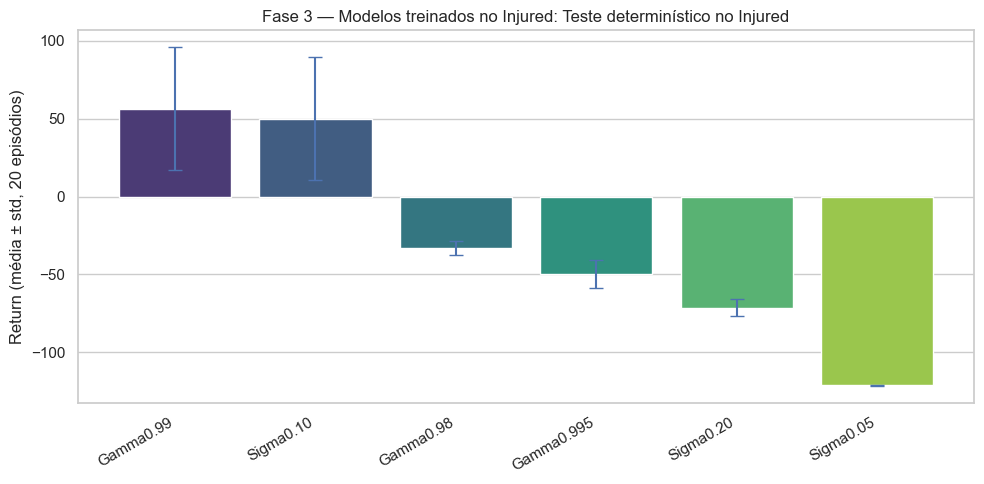

In [29]:
# --------- Gráfico 1: desempenho no Injured ----------
plt.figure(figsize=(10, 5))
sns.barplot(data=df_p3_sorted_inj, x="Config", y="Mean@Injured", palette="viridis")
plt.errorbar(
    x=np.arange(len(df_p3_sorted_inj)),
    y=df_p3_sorted_inj["Mean@Injured"],
    yerr=df_p3_sorted_inj["Std@Injured"],
    fmt="none", capsize=5
)
plt.title("Fase 3 — Modelos treinados no Injured: Teste determinístico no Injured")
plt.ylabel("Return (média ± std, 20 episódios)")
plt.xlabel("")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

C:\Users\franc\AppData\Local\Temp\ipykernel_11112\1734477102.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_p3_sorted_base, x="Config", y="Mean@Baseline", palette="viridis")


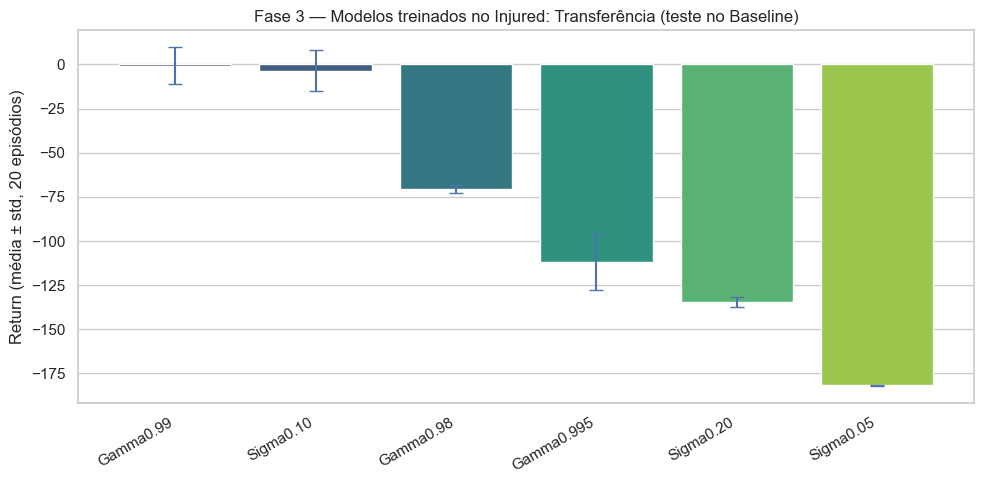

In [30]:
# --------- Gráfico 2: transferência para Baseline ----------
df_p3_sorted_base = df_p3.sort_values(by="Mean@Baseline", ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(data=df_p3_sorted_base, x="Config", y="Mean@Baseline", palette="viridis")
plt.errorbar(
    x=np.arange(len(df_p3_sorted_base)),
    y=df_p3_sorted_base["Mean@Baseline"],
    yerr=df_p3_sorted_base["Std@Baseline"],
    fmt="none", capsize=5
)
plt.title("Fase 3 — Modelos treinados no Injured: Transferência (teste no Baseline)")
plt.ylabel("Return (média ± std, 20 episódios)")
plt.xlabel("")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

* **Teste determinístico no Injured**: há uma separação clara em dois regimes:

  * **Melhores médias**:

    * **Gamma0.99**: **56.52 ± 39.32**
    * **Sigma0.10**: **50.13 ± 39.57**
      Estes valores são os mais altos no Injured, mas vêm com **variância muito elevada**, indicando políticas que **por vezes conseguem episódios razoáveis**, mas falham frequentemente.
  * **Políticas consistentes mas fracas** (std baixa, retorno negativo):

    * **Gamma0.98**: **−33.10 ± 4.49**
    * **Gamma0.995**: **−49.70 ± 9.03**
    * **Sigma0.20**: **−71.28 ± 5.43**
    * **Sigma0.05**: **−121.16 ± 0.24**
      Aqui a leitura é de **convergência estável para estratégias insuficientes**, especialmente com **σ=0.05**, que é claramente a pior (exploração insuficiente).

* **Transferência para o Baseline (teste no ambiente saudável)**: a transferência é, no geral, **má**, treinar no lesionado parece induzir uma política “adaptada” que não generaliza para a dinâmica saudável.

  * As duas melhores no Injured (**Gamma0.99** e **Sigma0.10**) ficam perto de **0** no Baseline (**−0.71 ± 10.38** e **−3.50 ± 11.80**), isto é, **não resolvem** o ambiente saudável.
  * As restantes degradam ainda mais (ex.: **Sigma0.05** chega a **−181.81 ± 0.11**), reforçando que a política aprendida no lesionado não só não resolve o baseline como pode ser **anti-transferível**.

**Síntese:**

* Sequindo o critério  de **maximizar retorno no Injured**, as melhores escolhas são **Gamma0.99** ou **Sigma0.10**, mas com o alerta de que são **muito instáveis** (Std ≈ 39).
* Seguindo o critério de **consistência**, **Gamma0.98** é mais estável, mas não atinge desempenho positivo no Injured.
* Em qualquer caso, a **transferência inversa (Injured → Baseline)** é fraca, sugerindo que a adaptação à lesão produz uma política especializada (possivelmente conservadora/assimétrica).


<a id="sec3"></a>
## 3. Análise Comportamental e Comparação de Resultados

Nesta secção, vamos além da simples métrica de recompensa (score) para entender a **qualidade e o estilo** da marcha do agente. Como introduzimos uma assimetria física no robô (perda de potência numa perna), é crucial investigar como o agente adaptou a sua política de controlo.

### 3.1 Distribuição das ações por motor
O objetivo desta análise é verificar se o agente aprendeu a compensar a lesão. Num robô saudável, esperamos uma distribuição de força simétrica entre as pernas esquerda e direita. No **InjuredBipedalWalker**, a perna direita (L - Lesionada) tem 70% menos força.

**O que vamos testar:**
Recolhemos as ações de um episódio completo e visualizamos a distribuição do torque aplicado em cada uma das 4 juntas:
1.  **Hip 1 / Knee 1:** Perna Saudável (S).
2.  **Hip 2 / Knee 2:** Perna Lesionada (L).

Esperamos observar uma **assimetria** nas caixas (boxplots), indicando que o agente está a "esforçar-se" de maneira diferente em cada lado para manter o equilíbrio.

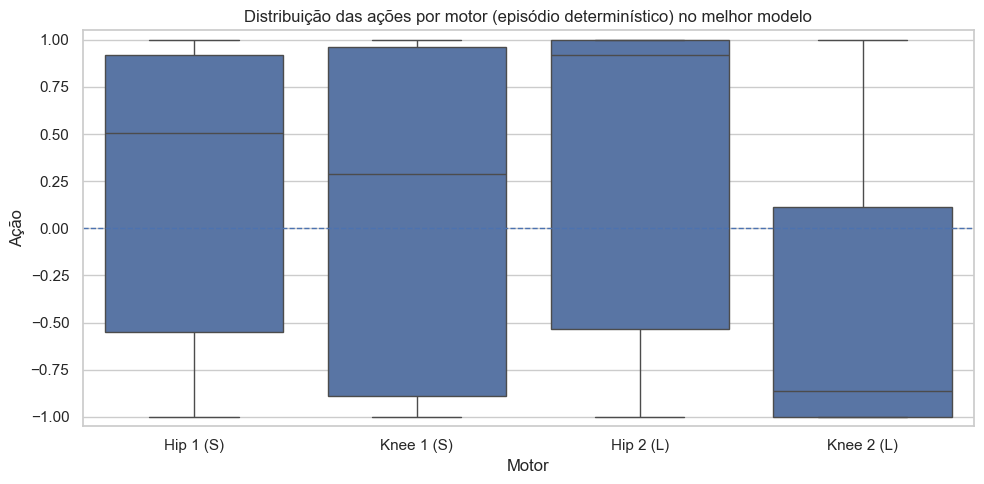

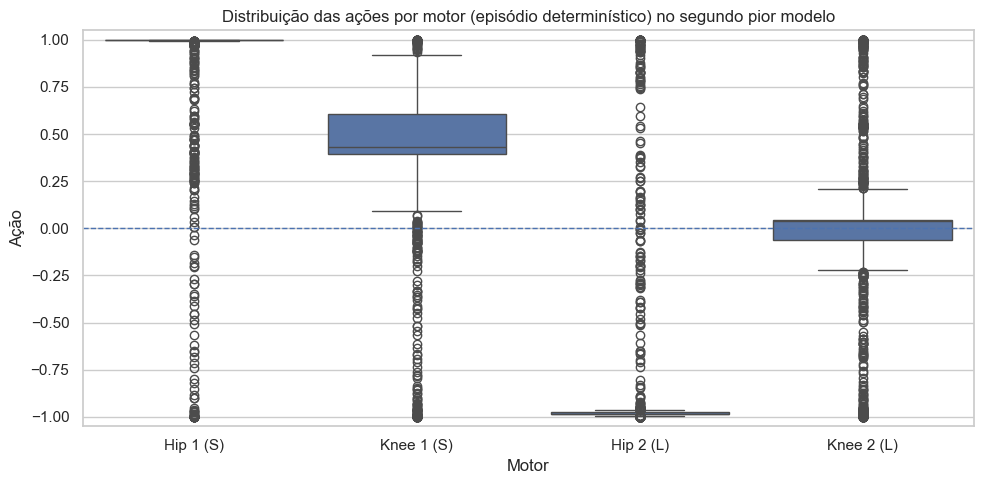

In [ ]:
def rollout_collect_actions(model, env_id, seed=42, max_steps=2000):
    env = gym.make(env_id)
    obs, _ = env.reset(seed=seed)

    actions = []
    hull_angles = []
    done, truncated = False, False
    steps = 0

    while not (done or truncated) and steps < max_steps:
        action, _ = model.predict(obs, deterministic=True)
        actions.append(action.copy())

        # hull angle é obs[0] no BipedalWalker (Hull Angle)
        hull_angles.append(float(obs[0]))

        obs, _, done, truncated, _ = env.step(action)
        steps += 1

    env.close()
    actions = np.array(actions)  # shape (T, 4)
    hull_angles = np.array(hull_angles)
    return actions, hull_angles

# exemplo: melhor modelo treinado no ambiente modificado
PATH_MODELO_IJURED_BEST = "../models/fase3_injured/TD3_Gamma0.99" 
model_best = TD3.load(PATH_MODELO_IJURED_BEST, device="cpu") 
actions_best, hull_angles_best = rollout_collect_actions(model_best, ENV_ID_MODIFIED, seed=42)

df_a = pd.DataFrame(actions_best, columns=["Hip 1 (S)", "Knee 1 (S)", "Hip 2 (L)", "Knee 2 (L)"])
df_long = df_a.melt(var_name="Motor", value_name="Ação")

plt.figure(figsize=(10,5))
sns.boxplot(data=df_long, x="Motor", y="Ação")
plt.title("Distribuição das ações por motor (episódio determinístico) no melhor modelo")
plt.ylim(-1.05, 1.05)
plt.axhline(0, linestyle="--", linewidth=1)
plt.tight_layout()
plt.show()

# exemplo: segundo pior modelo treinado no ambiente modificado
PATH_MODELO_IJURED_WORSE = "../models/fase3_injured/TD3_Sigma0.20" 
model_worst = TD3.load(PATH_MODELO_IJURED_WORSE, device="cpu") 
actions_worst, hull_angles_worst = rollout_collect_actions(model_worst, ENV_ID_MODIFIED, seed=42)

df_a = pd.DataFrame(actions_worst, columns=["Hip 1 (S)", "Knee 1 (S)", "Hip 2 (L)", "Knee 2 (L)"])
df_long = df_a.melt(var_name="Motor", value_name="Ação")

plt.figure(figsize=(10,5))
sns.boxplot(data=df_long, x="Motor", y="Ação")
plt.title("Distribuição das ações por motor (episódio determinístico) no segundo pior modelo")
plt.ylim(-1.05, 1.05)
plt.axhline(0, linestyle="--", linewidth=1)
plt.tight_layout()
plt.show()



#### Análise: assimetria e estratégia de compensação (ações por motor)

Os *boxplots* acima comparam o padrão de controlo do **melhor modelo** (TD3, **γ=0.99**) com um modelo de desempenho inferior (TD3, **σ=0.20**) no ambiente lesionado.

**1. Melhor modelo (TD3 γ=0.99)**

* **Uso ativo de múltiplos motores:** o agente explora uma **amplitude elevada** de ações nos três primeiros atuadores (*Hip 1*, *Knee 1* e *Hip 2*), com valores frequentemente próximos dos extremos. Isto é consistente com uma política que tenta manter propulsão e equilíbrio através de correções vigorosas.
* **Assimetria marcada no joelho lesionado (Knee 2 – L):** ao contrário dos restantes motores, o **Knee 2** apresenta uma distribuição deslocada para valores **mais negativos** e com mediana claramente abaixo de zero. Esta assimetria sugere uma estratégia específica para a perna lesionada: em vez de “insistir” em grandes torques simétricos, o agente parece favorecer um padrão mais direcional (p.ex., manter o joelho mais “fechado”/controlado), possivelmente para **reduzir instabilidade** e evitar quedas.

**2. Modelo inferior (TD3 σ=0.20)**

* **Exploração excessiva e controlo pouco estruturado:** a presença de muitos pontos dispersos e a falta de um padrão estável (especialmente em *Hip 1* e *Knee 2*) indicam ações com elevada variabilidade episódio-a-episódio, típica de uma política que não consolidou uma marcha robusta.
* **Sinal de “entrave” num motor crítico:** observa-se o *Hip 2 (L)* concentrado perto de **−1** (com caixa muito estreita), sugerindo saturação persistente do atuador. Este comportamento é geralmente sintoma de uma política que aplica correções extremas de forma repetitiva, o que tende a degradar a estabilidade e a eficiência energética, contribuindo para retornos baixos.

**Conclusão parcial:** no ambiente lesionado, o desempenho superior parece associado a uma **assimetria deliberada e controlada**, em particular no **Knee 2 (perna lesionada)**, combinada com uso amplo dos restantes motores. Já a configuração com **σ=0.20** evidencia sinais de **controlo ruidoso e/ou saturação**, sugerindo que a exploração elevada dificultou a convergência para um padrão locomotor estável.


### 3.2 Estabilidade do Tronco (Hull Angle)

A estabilidade do tronco é um proxy direto para o equilíbrio. Num caminhar humano eficiente, a cabeça e o tronco mantêm-se relativamente estáveis, com oscilações suaves.

**O que vamos testar:**
Vamos mostar o ângulo do tronco (`Hull Angle`) ao longo do tempo.
* **Linha perto de zero:** O robô está direito.
* **Oscilações regulares:** Indicam o ciclo de passada (esquerda-direita).
* **Picos abruptos ou deriva:** Indicam perda de equilíbrio, tropeções ou uma marcha "coxa" muito acentuada.

Também compararemos como o **mesmo agente** se comporta no ambiente *Saudável* vs *Lesionado* para visualizar o impacto direto da avaria mecânica na estabilidade.

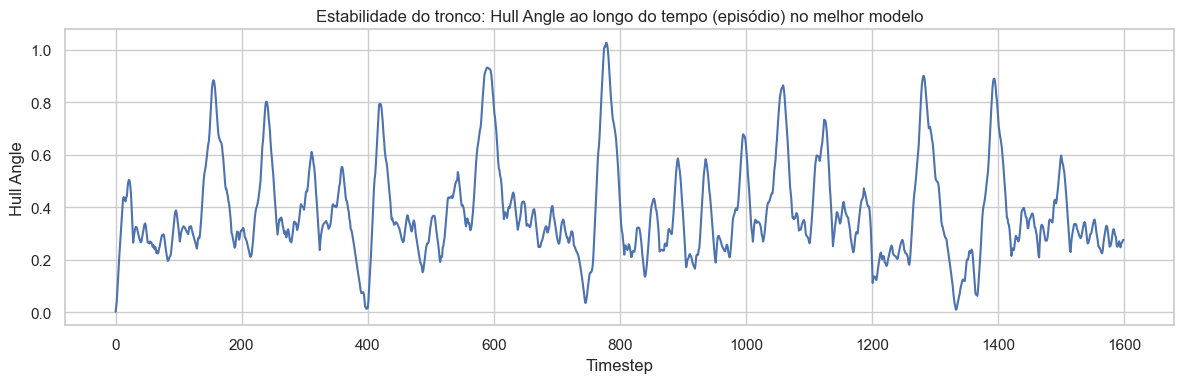

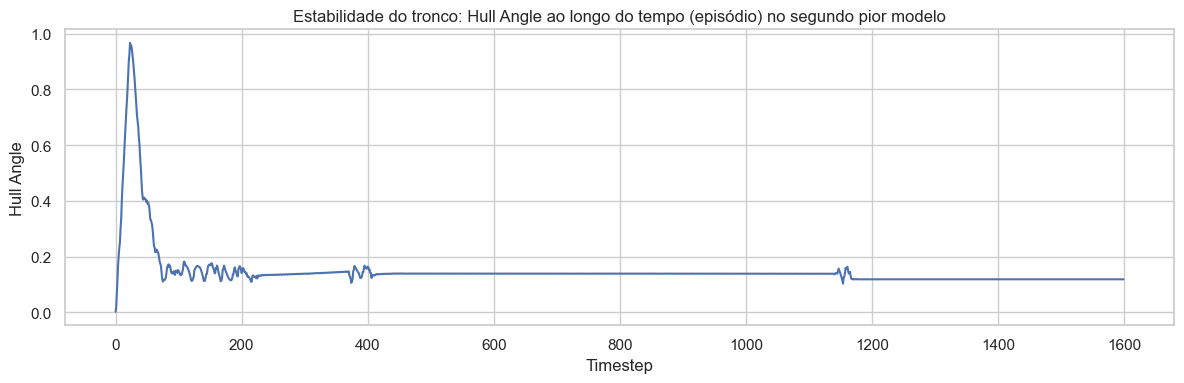

In [54]:
plt.figure(figsize=(12,4))
sns.lineplot(x=np.arange(len(hull_angles_best)), y=hull_angles_best)
plt.title("Estabilidade do tronco: Hull Angle ao longo do tempo (episódio) no melhor modelo")
plt.xlabel("Timestep")
plt.ylabel("Hull Angle")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
sns.lineplot(x=np.arange(len(hull_angles_worst)), y=hull_angles_worst)
plt.title("Estabilidade do tronco: Hull Angle ao longo do tempo (episódio) no segundo pior modelo")
plt.xlabel("Timestep")
plt.ylabel("Hull Angle")
plt.tight_layout()
plt.show()


#### Análise: estabilidade do tronco e evidência de “marcha compensatória”

Os gráficos do **Hull Angle** permitem observar, de forma direta, o compromisso entre **propulsão** e **equilíbrio** no ambiente lesionado. A leitura é particularmente útil para distinguir entre (i) políticas que **mantêm controlo mas progridem pouco** e (ii) políticas que **tentam progredir** à custa de oscilações maiores (potencialmente instáveis).

**1. Melhor modelo (episódio no ambiente modificado)**

* O traçado apresenta uma oscilação **persistente e relativamente estruturada**, com o ângulo a manter-se grande parte do tempo num “corredor” em torno de ~0.2–0.4, mas com **picos periódicos** que chegam perto de 0.9–1.0.
* Estes picos sugerem uma estratégia de **transferência agressiva do centro de massa**: o agente inclina o tronco de forma pronunciada para gerar *momentum* e compensar a perda de força na perna direita.
* Importante: apesar das excursões elevadas, o ângulo **não diverge** nem colapsa para valores incompatíveis com equilíbrio, o que indica que o agente consegue **recuperar o controlo** após correções fortes. Em termos comportamentais, isto é compatível com um “andar a coxear” (compensatório), mais energético e menos suave, mas funcional.

**2. Modelo inferior (episódio no ambiente modificado)**

* Observa-se um **pico inicial muito elevado** seguido de uma rápida estabilização num valor quase constante (~0.12–0.15) durante a maior parte do episódio.
* Esta assinatura é típica de uma política que **não estabelece uma marcha dinâmica**: após a perturbação inicial, o agente entra num regime quase estacionário (muito pouco balanço), o que é consistente com o padrão visto nas ações (controlo pouco eficaz e/ou saturações) e com desempenhos baixos por **falta de progressão**.
* Ou seja, mais do que “cair”, este modelo parece **não conseguir gerar propulsão suficiente**, mantendo o tronco pouco variável mas sem avançar de forma competente.

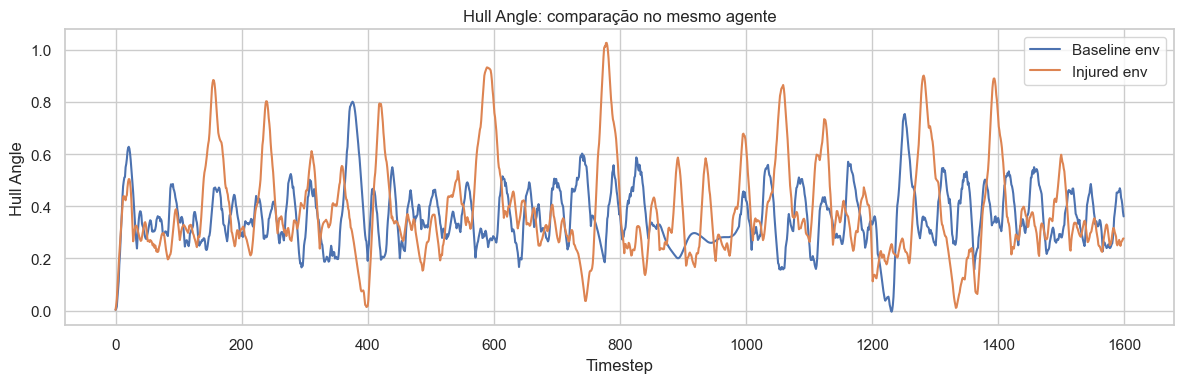

In [55]:
actions_b, angles_b = rollout_collect_actions(model_best, ENV_ID_BASELINE, seed=42)
actions_i, angles_i = rollout_collect_actions(model_best, ENV_ID_MODIFIED, seed=42)

plt.figure(figsize=(12,4))
sns.lineplot(x=np.arange(len(angles_b)), y=angles_b, label="Baseline env")
sns.lineplot(x=np.arange(len(angles_i)), y=angles_i, label="Injured env")
plt.title("Hull Angle: comparação no mesmo agente")
plt.xlabel("Timestep"); plt.ylabel("Hull Angle")
plt.tight_layout(); plt.show()


**3. Mesmo agente: Baseline vs. Injured**

* No **ambiente baseline** (azul), o ângulo mantém-se mais contido e com oscilações menores, refletindo uma marcha mais “económica” e simétrica.
* No **ambiente injured** (laranja), surgem oscilações mais pronunciadas e picos mais frequentes, evidenciando que a lesão força o agente a recorrer a **maior inclinação do tronco** para compensar a perda de potência, uma deterioração clara da estabilidade *natural* do movimento.

**Conclusão parcial:** a lesão não se manifesta apenas como queda de retorno; ela altera o **regime de estabilidade** do agente. O melhor modelo mantém desempenho superior precisamente porque aceita um padrão de marcha **mais oscilatório**, mas ainda controlado, enquanto o modelo inferior tende a um regime **quase passivo**, consistente com falhas por **estagnação** em vez de quedas explosivas.


### 3.3 Análise de falhas: como o agente perde?

Para complementar o retorno, analisamos o **modo de terminação** em múltiplos episódios no ambiente lesionado. Classificamos cada episódio em:

- **Sucesso:** retorno elevado (próximo do desempenho ótimo).
- **Queda:** terminação abrupta associada a forte penalização (compatível com instabilidade).
- **Timeout / estagnação:** terminação por limite de tempo ou progresso insuficiente.

Esta decomposição distingue dois regimes qualitativamente diferentes:

- Predomínio de **quedas** → política agressiva e instável (tenta manter uma marcha “normal”, mas perde equilíbrio sob dinâmica alterada).
- Predomínio de **timeouts** → política conservadora (evita queda, mas não consegue gerar progressão suficiente).

> **Nota crítica:** a classificação aqui é heurística (baseada em retorno e flags `terminated/truncated`). Apesar de simples, é informativa para interpretar se a degradação se deve sobretudo a **instabilidade** ou a **insuficiência de controlo/força**.


label
Timeout    96
Queda       4
Name: count, dtype: int64

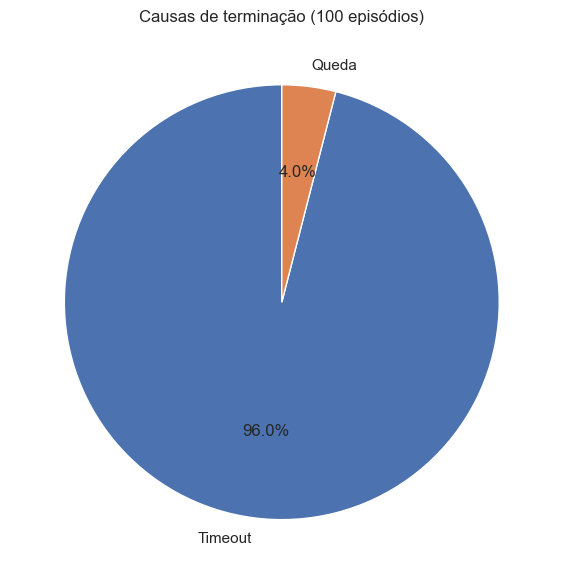

In [49]:
def classify_termination(total_return, terminated, truncated, success_threshold=280, fall_threshold=-50):
    # heurística:
    # - sucesso: retorno muito alto
    # - queda: terminou (terminated) com retorno muito baixo (punição forte)
    # - timeout: truncated ou "não caiu mas não avançou"
    if total_return >= success_threshold:
        return "Sucesso"
    if terminated and total_return <= fall_threshold:
        return "Queda"
    if truncated:
        return "Timeout"
    return "Outro"

def termination_stats(model, env_id, episodes=100, seed=0):
    env = gym.make(env_id)
    labels = []
    returns = []
    for ep in range(episodes):
        obs, _ = env.reset(seed=seed + ep)
        done, truncated = False, False
        total = 0.0
        while not (done or truncated):
            action, _ = model.predict(obs, deterministic=True)
            obs, r, done, truncated, _ = env.step(action)
            total += float(r)
        labels.append(classify_termination(total, done, truncated))
        returns.append(total)
    env.close()
    df = pd.DataFrame({"label": labels, "return": returns})
    return df

df_term = termination_stats(model_best, ENV_ID_MODIFIED, episodes=100, seed=42)
display(df_term["label"].value_counts())

plt.figure(figsize=(6,6))
df_counts = df_term["label"].value_counts().reset_index()
df_counts.columns = ["label", "count"]
plt.pie(df_counts["count"], labels=df_counts["label"], autopct="%1.1f%%", startangle=90)
plt.title("Causas de terminação (100 episódios)")
plt.tight_layout()
plt.show()


#### Análise de robustez: causas de terminação (100 episódios)

O gráfico de causas de terminação clarifica **como** o agente falha no ambiente lesionado, indo além da média de retorno:

* **Timeout (96%)**: a esmagadora maioria dos episódios termina por **limite de tempo**, o que indica que o agente **raramente colapsa por instabilidade**, mas também **não progride o suficiente** para completar a tarefa de forma competente. Este padrão é típico de uma política que privilegia “**não cair**” (estabilidade) à custa de velocidade/propulsão.
* **Queda (4%)**: a taxa de quedas é relativamente baixa, sugerindo que o agente aprendeu um controlador que, na maioria das trajetórias, consegue manter o equilíbrio mesmo sob dinâmica degradada. No entanto, a presença de algumas quedas confirma que o comportamento ainda é **sensível** a certas configurações do terreno/oscilações (episódios em que a compensação falha).

**Implicação crítica:** apesar de ser o melhor modelo desta fase, o desempenho continua limitado principalmente por **ineficiência locomotora** (progressão insuficiente) e não por falta de equilíbrio. Isto alinha-se com as evidências comportamentais: o agente utiliza uma marcha compensatória (assimétrica e mais oscilatória), mas essa estratégia não se traduz, na maioria dos casos, em avanço suficiente dentro do horizonte do episódio.

**Conclusão geral da análise comportamental:** o TD3 **γ=0.99** apresenta a melhor combinação observada entre *score* e controlo no ambiente lesionado, desenvolvendo uma estratégia de compensação coerente (padrões de ação assimétricos e oscilações do tronco recuperáveis). Contudo, os resultados mostram que a robustez atingida é sobretudo do tipo **“sobrevivência”** (evitar quedas), permanecendo como principal limitação a **capacidade de gerar propulsão consistente**.


<a id="sec4"></a>
## 4. Conclusão

In [59]:
def show_videos_side_by_side(path_left, title_left, path_right, title_right, width=420):
    return HTML(f"""
    <div style="display:flex; gap:18px; align-items:flex-start;">
      <div style="flex:1;">
        <div style="font-weight:600; margin-bottom:6px;">{title_left}</div>
        <video width="{width}" controls loop autoplay muted style="border-radius:10px; border:1px solid #ddd;">
          <source src="{path_left}" type="video/mp4">
        </video>
      </div>
      <div style="flex:1;">
        <div style="font-weight:600; margin-bottom:6px;">{title_right}</div>
        <video width="{width}" controls loop autoplay muted style="border-radius:10px; border:1px solid #ddd;">
          <source src="{path_right}" type="video/mp4">
        </video>
      </div>
    </div>
    """)

show_videos_side_by_side(
    "../videos/TD3_Miope-episode-0.mp4", "Treinado no Baseline: TD3 Míope (γ=0.98) — teste no Baseline",
    "../videos/TD3_InjuredBest-episode-0.mp4", "Treinado no Injured: TD3 (γ=0.99) — teste no Injured",
)


### Conclusão do vídeo comparativo (Baseline vs. Injured)

O vídeo coloca em evidência duas políticas **intrínsecamente diferentes**:

* **TD3-Míope (γ=0.98), treinado no Baseline**

  * marcha **mais fluida** e **eficiente** quando a dinâmica é saudável
  * evidenciado pelo desempenho muito mais positivo

* **TD3 (γ=0.99), treinado no Injured**

  * marcha **mais assimétrica** e **mais oscilatória** (*compensatória*)
  * consegue **manter-se de pé com maior frequência**, mas muitas vezes progride pouco → **timeouts** são comuns
  * é um exemplo claro de robustez como **adaptação à falha**, apesar de raramente andar sem ser ao arrastar-se

> **Inferência:** no ambiente lesionado, a política mais eficaz não é a mais “suave”, mas a que consegue **compensar** a dinâmica degradada sem colapsar.

---

## Conlusão final do trabalho

### 1) O problema e a modificação do ambiente

* Partimos do **BipedalWalker-v3** (controlo contínuo, recompensa densa).
* Propusemos o **InjuredBipedalWalker**, introduzindo uma falha mecânica realista:
  **redução de força na perna direita**, mantendo observações e recompensas.
* Objetivo global: estudar **robustez** e **adaptação** a uma alteração **dinâmica**.

---

### 2) O que foi feito em cada notebook

**Notebook 1 — Caracterização**

* definimos o MDP (estado, ações, recompensa)
* documentámos e validámos a compatibilidade Gymnasium do ambiente modificado

**Notebook 2 — Seleção e tuning no Baseline**

* comparamos **PPO, SAC, A2C, TD3** com protocolo reprodutível
* separámos claramente:

  * treino (curvas com ruído)
  * teste (avaliação determinística)
* escolhemos **TD3** e afinámos hiperparâmetros
* baseline final: **TD3-Míope (LR=1e−3, γ=0.98)**, por **alto retorno** e **baixa variância**

**Notebook 3 — Robustez, treino no Injured e análise crítica**

* avaliámos a **generalização**: baseline → baseline vs injured
  → queda forte no Injured ⇒ fragilidade a *shift* dinâmico
* treinámos diretamente no Injured (tuning de **σ** e **γ**)
* melhor configuração no Injured: **γ=0.99**, mas com:

  * variância elevada
  * falhas dominadas por **timeouts (≈96%)** ⇒ o problema passa a ser **progresso**, não tanto “cair”

---

### 3) Principais conclusões (com evidência)

* **Robustez ≠ desempenho no Baseline:** uma política excelente no ambiente saudável pode falhar quase completamente sob falha mecânica.
* **Treinar no Injured muda a estratégia:**

  * ações tornam-se **mais assimétricas**
  * tronco mostra maior oscilação ⇒ marcha **compensatória**
* **Falha dominante:** no melhor agente lesionado, a maioria dos episódios termina por **timeout**, o que indica que o agente aprendeu sobretudo a **sobreviver** (não cair), mas ainda não a **progredir com eficiência**.

---

### 4) Reflexão crítica e trabalho futuro

Para tornar o agente simultaneamente **adaptável** e **generalizável**, seria natural explorar:

* **Curriculum learning:** aumentar gradualmente a severidade do dano (0.9 → 0.3)
* **Domain randomization:** variar dano/terreno durante treino para forçar robustez
* **Estratégias robustas:** regularização, treino multi-task, ou políticas condicionadas no “nível de dano”

> **Mensagem final:** neste cenário, a análise não pode ficar apenas na média do retorno, é essencial olhar para **variância**, **modos de falha** e **comportamento motor**, porque é aí que a robustez (ou falta dela) realmente aparece.
